# Sleep stage classification: SVC
____

This model aims to classify sleep stages based on two EEG channel. We will use the features extracted in the `pipeline.ipynb` notebook as the input to a support vector classification (SVC).

We will only be looking at `LinearSVC`, because the `SVC` model implemented by scikitlearn has a quadratic time complexity. As it is stated in the docs, it may be impractical beyond tens of thousands of samples, which corresponds to our sample numbers.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Ensure parent folder is in PYTHONPATH
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline

from itertools import groupby

import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     GroupKFold,
                                     cross_validate)
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report,
                             f1_score,
                             cohen_kappa_score,
                             make_scorer)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier

from constants import (SLEEP_STAGES_VALUES,
                       N_STAGES,
                       EPOCH_DURATION)
from model_utils import (print_hypnogram,
                         train_test_split_one_subject,
                         train_test_split_according_to_age,
                         evaluate_hyperparams_grid,
                         print_results_cv,
                         print_results_cv_scores,
                         get_pipeline)

## Load the features
___

In [3]:
# position of the subject information and night information in the X matrix
SUBJECT_IDX = 0 
NIGHT_IDX = 1
USE_CONTINUOUS_AGE = False
DOWNSIZE_SET = False
TEST_SET_SUBJECTS = [0.0, 24.0, 49.0, 71.0]

if USE_CONTINUOUS_AGE:
    X_file_name = "../data/x_features-age-continuous.npy"
    y_file_name = "../data/y_observations-age-continuous.npy"
else:
    X_file_name = "../data/x_features.npy"
    y_file_name = "../data/y_observations.npy"

In [4]:
X_init = np.load(X_file_name, allow_pickle=True)
y_init = np.load(y_file_name, allow_pickle=True)

X_init = np.vstack(X_init)
y_init = np.hstack(y_init)
print(X_init.shape)
print(y_init.shape)
print("Number of subjects: ", np.unique(X_init[:,SUBJECT_IDX]).shape[0]) # Some subject indexes are skipped, thus total number is below 83 (as we can see in https://physionet.org/content/sleep-edfx/1.0.0/)
print("Number of nights: ", len(np.unique([f"{int(x[0])}-{int(x[1])}" for x in X_init[:,SUBJECT_IDX:NIGHT_IDX+1]])))
print("Subjects available: ", np.unique(X_init[:,SUBJECT_IDX]))

(168954, 50)
(168954,)
Number of subjects:  78
Number of nights:  153
Subjects available:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 70. 71. 72. 73. 74.
 75. 76. 77. 80. 81. 82.]


In [5]:
X_test, X_train_valid, y_test, y_train_valid = train_test_split_according_to_age(
    X_init,
    y_init,
    use_continuous_age=USE_CONTINUOUS_AGE,
    subjects_test=TEST_SET_SUBJECTS)
    
print(X_test.shape, X_train_valid.shape, y_test.shape, y_train_valid.shape)

Selected subjects for the test set are:  [0.0, 24.0, 49.0, 71.0]
(8123, 50) (160831, 50) (8123,) (160831,)


## LinearSVC validation
____


In [6]:
NB_KFOLDS = 5
NB_CATEGORICAL_FEATURES = 2
NB_FEATURES = 48
CLASSIFIER_PIPELINE_KEY = 'classifier'
RANDOM_STATE = 42 

def get_cv_iterator(n_splits=2):
    return GroupKFold(n_splits=n_splits).split(
        X_train_valid, groups=X_train_valid[:,SUBJECT_IDX]
    )
    
def cross_validate_with_confusion_matrix(pipeline, n_fold):
    accuracies = []
    macro_f1_scores = []
    weighted_f1_scores = []
    kappa_agreements = []

    for train_index, valid_index in get_cv_iterator(n_splits=n_fold):
        # We drop the subject and night indexes
        X_train, X_valid = X_train_valid[train_index, 2:], X_train_valid[valid_index, 2:]
        y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

        # Scaling features and model training
        training_pipeline = pipeline
        training_pipeline.fit(X_train, y_train)

        # Validation
        y_valid_pred = training_pipeline.predict(X_valid)

        print("----------------------------- FOLD RESULTS --------------------------------------\n")
        current_kappa = cohen_kappa_score(y_valid, y_valid_pred)

        print("TRAIN:", train_index, "VALID:", valid_index, "\n\n")
        print(confusion_matrix(y_valid, y_valid_pred), "\n")
        print(classification_report(y_valid, y_valid_pred, target_names=SLEEP_STAGES_VALUES.keys()), "\n")
        print("Agreement score (Cohen Kappa): ", current_kappa, "\n")

        accuracies.append(round(accuracy_score(y_valid, y_valid_pred),2))
        macro_f1_scores.append(f1_score(y_valid, y_valid_pred, average="macro"))
        weighted_f1_scores.append(f1_score(y_valid, y_valid_pred, average="weighted"))
        kappa_agreements.append(current_kappa)

    print_results_cv(accuracies, macro_f1_scores, weighted_f1_scores, kappa_agreements)

In [7]:
%%time

cross_validate_with_confusion_matrix(get_pipeline(
    classifier=LinearSVC(
        dual=False, # Prefer dual=False when n_samples > n_features. (documentation)
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
), n_fold=NB_KFOLDS)

----------------------------- FOLD RESULTS --------------------------------------

TRAIN: [  2137   2138   2139 ... 158843 158844 158845] VALID: [     0      1      2 ... 160828 160829 160830] 


[[6586  357  227   49  433]
 [ 848  597 1317   18  937]
 [ 647  228 9594 1044 1425]
 [  31    1  377 2489   33]
 [ 668  680 1025    9 3184]] 

              precision    recall  f1-score   support

           W       0.75      0.86      0.80      7652
          N1       0.32      0.16      0.21      3717
          N2       0.77      0.74      0.75     12938
          N3       0.69      0.85      0.76      2931
         REM       0.53      0.57      0.55      5566

    accuracy                           0.68     32804
   macro avg       0.61      0.64      0.62     32804
weighted avg       0.66      0.68      0.67     32804
 

Agreement score (Cohen Kappa):  0.5731451107412158 

----------------------------- FOLD RESULTS --------------------------------------

TRAIN: [     0      1      2 ... 1

CV Results:
```
Mean accuracy          : 0.70 ± 0.026
Mean macro F1-score    : 0.63 ± 0.025
Mean weighted F1-score : 0.69 ± 0.026
Mean Kappa's agreement : 0.59 ± 0.039
```

## Validation results
___

### Dimension reduction
___

*Definitions from scikit learn*:

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

We will compare each method and keep the one with the best results.



In [8]:
def cross_validate_with_dim_reduction(dim_reduction):
    scores = cross_validate(
        estimator=get_pipeline(
            classifier=LinearSVC(
                dual=False, # Prefer dual=False when n_samples > n_features. (documentation)
                class_weight="balanced",
                random_state=RANDOM_STATE
            ),
            dimension_reduction=dim_reduction
        ),
        X=X_train_valid,
        y=y_train_valid,
        groups=X_train_valid[:,SUBJECT_IDX],
        scoring={
            "agreement": make_scorer(cohen_kappa_score),
            "accuracy": 'accuracy',
            "f1-score-macro": 'f1_macro',
            "f1-score-weighted": 'f1_weighted',
        },
        cv=get_cv_iterator(n_splits=5),
        return_train_score=True,
        verbose=1,
        n_jobs=-1
    )

    print_results_cv_scores(scores)

#### 1. Linear discriminant analysis
___

LDA only allows `n_components` between 1 and `min(n_classes - 1, n_features)`. We will then **reduce our 48 features to 4 components**.

A particularity of LDA is that it has pratically no hyperparameters to fix (except the number of components, which is limited).

In [9]:
%%time

cross_validate_with_dim_reduction(LinearDiscriminantAnalysis())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.3s


Mean accuracy          : 0.69 ± 0.033
Mean macro F1-score    : 0.60 ± 0.030
Mean weighted F1-score : 0.67 ± 0.030
Mean Kappa's agreement : 0.57 ± 0.044
CPU times: user 65.1 ms, sys: 101 ms, total: 166 ms
Wall time: 13.9 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


#### 2. Principal component analysis
___

It is a non supervised dimension reduction method. In that sense, it can lead to worst results than LDA. On the other side, we can set the `n_components` to any value between 1 and `n_features`, which allows us to control the information that we leave out.

We've already looked at explained ratio by nb of components in the RF_HMM notebook. The results were:
```
1 components included: 0.9253
2 components included: 0.9405
4 components included: 0.9591
10 components included: 0.9807
16 components included: 0.9906
20 components included: 0.9943
30 components included: 0.9987
```

We will look at 4, 16 and 30 components.

In [10]:
%%time

cross_validate_with_dim_reduction(PCA(n_components=4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.4s


Mean accuracy          : 0.53 ± 0.018
Mean macro F1-score    : 0.46 ± 0.011
Mean weighted F1-score : 0.51 ± 0.011
Mean Kappa's agreement : 0.37 ± 0.025
CPU times: user 37.8 ms, sys: 44.4 ms, total: 82.2 ms
Wall time: 15.3 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


In [11]:
%%time

cross_validate_with_dim_reduction(PCA(n_components=16))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.6s


Mean accuracy          : 0.66 ± 0.028
Mean macro F1-score    : 0.58 ± 0.022
Mean weighted F1-score : 0.64 ± 0.025
Mean Kappa's agreement : 0.53 ± 0.037
CPU times: user 46.2 ms, sys: 40.3 ms, total: 86.5 ms
Wall time: 22.4 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


In [12]:
%%time

cross_validate_with_dim_reduction(PCA(n_components=30))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.2s remaining:  1.0min


Mean accuracy          : 0.69 ± 0.028
Mean macro F1-score    : 0.62 ± 0.027
Mean weighted F1-score : 0.68 ± 0.028
Mean Kappa's agreement : 0.58 ± 0.038
CPU times: user 58.7 ms, sys: 32.3 ms, total: 91 ms
Wall time: 42.1 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.1s finished


In [13]:
%%time

cross_validate_with_dim_reduction(PCA(n_components=35))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.5s remaining:  1.4min


Mean accuracy          : 0.70 ± 0.030
Mean macro F1-score    : 0.62 ± 0.027
Mean weighted F1-score : 0.69 ± 0.028
Mean Kappa's agreement : 0.59 ± 0.041
CPU times: user 40.6 ms, sys: 48.4 ms, total: 89 ms
Wall time: 56.4 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.3s finished


If we resume all our results, which we tested upon 5 folds, we have the following:

|  Score             |  without      | LDA           | PCA (n_comp=4) | PCA (n_comp=16) | PCA (n_comp=30) | PCA (n_comp=35) |
|--------------------|---------------|---------------|----------------|-----------------|-----------------|-----------------|
|  accuracy          | 0.70 ± 0.030  |  0.69 ± 0.033 | 0.53 ± 0.018   |  0.66 ± 0.028   |  0.69 ± 0.028   |  0.70 ± 0.030   |
|  macro F1-score    | 0.63 ± 0.027  |  0.60 ± 0.030 | 0.46 ± 0.011   |  0.58 ± 0.022   |  0.62 ± 0.027   |  0.62 ± 0.027   |
|  weighted F1-score | 0.69 ± 0.028  |  0.67 ± 0.030 | 0.51 ± 0.011   |  0.64 ± 0.025   |  0.68 ± 0.028   |  0.69 ± 0.028   |
|  Kappa's agreement | 0.59 ± 0.042  |  0.57 ± 0.044 | 0.37 ± 0.025   |  0.53 ± 0.037   |  0.58 ± 0.038   |  0.59 ± 0.041   |
|  Time              | 57.1 s        |  12 s         | 12.3 s         |  16.2 s         |  30 s           |  36 s           |

We will keep the PCA dimension reduction, with n_components=35, because it keeps the same accuracy, weighted F1-score and Cohen's Kappa as the model that doesn't not have dimension reduction. 

### Hyperparameters tuning
___

#### 1. `C`: Regularization parameter
___

Inverse of regularization strength. Like in support vector machines, smaller values specify stronger regularization. It controls the trade off between smooth decision boundary and classifying the training points correctly. Increasing C values may lead to overfitting the training data.

In [14]:
%%time

evaluate_hyperparams_grid(
    params={
        f"{CLASSIFIER_PIPELINE_KEY}__C": np.linspace(1.95, 2.3, 10)
    },
    estimator=get_pipeline(
        classifier=LinearSVC(
            dual=False, 
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        dimension_reduction=PCA(n_components=35)
    ),
    X=X_train_valid,
    y=y_train_valid,
    cv=get_cv_iterator(n_splits=5),
    use_randomized=False
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.3min finished


1. Parameter {'classifier__C': 1.95} has a score of 0.5903 ± 0.039
2. Parameter {'classifier__C': 2.1444444444444444} has a score of 0.5903 ± 0.039
2. Parameter {'classifier__C': 2.183333333333333} has a score of 0.5903 ± 0.039
2. Parameter {'classifier__C': 2.261111111111111} has a score of 0.5903 ± 0.039
5. Parameter {'classifier__C': 1.988888888888889} has a score of 0.5903 ± 0.039
5. Parameter {'classifier__C': 2.0277777777777777} has a score of 0.5903 ± 0.039
5. Parameter {'classifier__C': 2.1055555555555556} has a score of 0.5903 ± 0.039
8. Parameter {'classifier__C': 2.2222222222222223} has a score of 0.5903 ± 0.039
9. Parameter {'classifier__C': 2.3} has a score of 0.5903 ± 0.039
10. Parameter {'classifier__C': 2.0666666666666664} has a score of 0.5903 ± 0.039
CPU times: user 26 s, sys: 2.88 s, total: 28.9 s
Wall time: 8min 40s


**Results**:

|Rank| C                | Test score     |
|----|------------------|----------------|
|1   | 2.236842105263158| 0.5903 ± 0.039 |
|2   | 1.931578947368421| 0.5902 ± 0.039 |
|3   | 2.389473684210526| 0.5902 ± 0.039 |
...

CPU times: user 13.1 s, sys: 998 ms, total: 14.1 s
Wall time: 5min 28s

Other values gave the same test score (`0.5902 ± 0.039`): `0.557894, 1.626315, 1.473684, 1.015789, ... 2.847368`. We then looked at the range between 1.95 and 2.3:

|Rank| C                | Test score     |
|----|------------------|----------------|
|1   | 2.105            | 0.5903 ± 0.039 |
|2   | 2.144            | 0.5902 ± 0.039 |
|3   | 2.183            | 0.5902 ± 0.039 |
...

CPU times: user 13.4 s, sys: 1.19 s, total: 14.6 s
Wall time: 5min 53s

We then fixed the value to `2.105`.

## Meta-estimators
___

In [15]:
%%time

adaboosted_pipeline = Pipeline([
    ('scaling', ColumnTransformer([
        ('pass-through-categorical', 'passthrough', list(range(NB_CATEGORICAL_FEATURES))),
        ('scaling-continuous', StandardScaler(copy=False), list(range(NB_CATEGORICAL_FEATURES,NB_FEATURES)))
    ])),
    ("dim_reduction", PCA(n_components=35)),
    (CLASSIFIER_PIPELINE_KEY, AdaBoostClassifier(
        LinearSVC(
            C=2.105,
            dual=False,
            class_weight="balanced",
#             random_state=RANDOM_STATE
        ),
        algorithm='SAMME',
        n_estimators=100,
        random_state=RANDOM_STATE
    ))
])

scores = cross_validate(
    estimator=adaboosted_pipeline,
    X=X_train_valid,
    y=y_train_valid,
    groups=X_train_valid[:,SUBJECT_IDX],
    scoring={
        "agreement": make_scorer(cohen_kappa_score),
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
    cv=get_cv_iterator(n_splits=2),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

print_results_cv_scores(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Mean accuracy          : 0.67 ± 0.004
Mean macro F1-score    : 0.60 ± 0.005
Mean weighted F1-score : 0.67 ± 0.003
Mean Kappa's agreement : 0.55 ± 0.001
CPU times: user 41.9 ms, sys: 28.7 ms, total: 70.6 ms
Wall time: 39.6 s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.6s finished


Results:

```
Mean accuracy          : 0.67 ± 0.003
Mean macro F1-score    : 0.60 ± 0.005
Mean weighted F1-score : 0.66 ± 0.003
Mean Kappa's agreement : 0.55 ± 0.001
CPU times: user 49.7 ms, sys: 57 ms, total: 107 ms
Wall time: 30.5 s
```
The results have not been improved compared to the same model without the `AdaBoost` meta-estimator.

## SVM testing
___

In [16]:
%%time

testing_pipeline = get_pipeline(
    classifier=LinearSVC(
        dual=False,
        C=2.105,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    dimension_reduction=PCA(n_components=35)
)

testing_pipeline.fit(X_train_valid[:, 2:], y_train_valid);

CPU times: user 26 s, sys: 3.11 s, total: 29.1 s
Wall time: 24.9 s


Pipeline(memory=None,
         steps=[('scaling',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pass-through-categorical',
                                                  'passthrough', [0, 1]),
                                                 ('scaling-continuous',
                                                  StandardScaler(copy=False,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28,

In [17]:
y_test_pred = testing_pipeline.predict(X_test[:,2:])

print(confusion_matrix(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_test, y_test_pred))

[[1437   51    8   24  104]
 [ 254  233  301    2  193]
 [  77   88 3018  331   89]
 [   3    0   14  594    0]
 [  95  159  243    2  803]]
              precision    recall  f1-score   support

           W       0.77      0.88      0.82      1624
          N1       0.44      0.24      0.31       983
          N2       0.84      0.84      0.84      3603
          N3       0.62      0.97      0.76       611
         REM       0.68      0.62      0.64      1302

    accuracy                           0.75      8123
   macro avg       0.67      0.71      0.68      8123
weighted avg       0.74      0.75      0.73      8123

Agreement score (Cohen Kappa):  0.6506513702343493


### Test results
___

#### a) Without PCA and without tuning (C=1)
___

```
[[1443   48    7   24  102]
 [ 244  244  298    4  193]
 [  71   89 3037  318   88]
 [   4    0   16  591    0]
 [  97  161  240    3  801]]
              precision    recall  f1-score   support

           W       0.78      0.89      0.83      1624
          N1       0.45      0.25      0.32       983
          N2       0.84      0.84      0.84      3603
          N3       0.63      0.97      0.76       611
         REM       0.68      0.62      0.64      1302

    accuracy                           0.75      8123
   macro avg       0.68      0.71      0.68      8123
weighted avg       0.74      0.75      0.74      8123

Agreement score (Cohen Kappa):  0.6557078634244826

```

#### b) Without PCA and with tuning (C=2.105)
___

```
              precision    recall  f1-score   support

           W       0.78      0.89      0.83      1624
          N1       0.45      0.25      0.32       983
          N2       0.84      0.84      0.84      3603
          N3       0.63      0.97      0.76       611
         REM       0.68      0.62      0.64      1302

    accuracy                           0.75      8123
   macro avg       0.67      0.71      0.68      8123
weighted avg       0.74      0.75      0.74      8123

Agreement score (Cohen Kappa):  0.6555409806957044
```

#### c) With PCA and tuning (C=2.105)
___

```
              precision    recall  f1-score   support

           W       0.77      0.88      0.82      1624
          N1       0.44      0.24      0.31       983
          N2       0.84      0.84      0.84      3603
          N3       0.62      0.97      0.76       611
         REM       0.68      0.62      0.64      1302

    accuracy                           0.75      8123
   macro avg       0.67      0.71      0.68      8123
weighted avg       0.74      0.75      0.73      8123

Agreement score (Cohen Kappa):  0.6506513702343493
```

Test subjects are subjects:  [ 0. 24. 49. 71.]


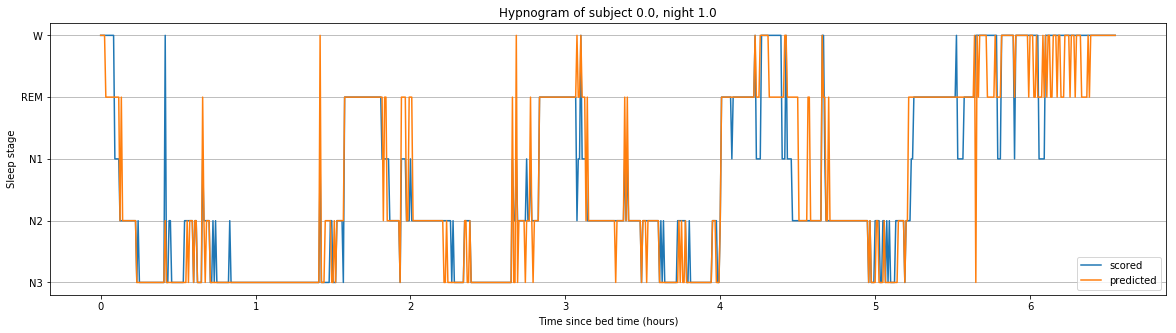

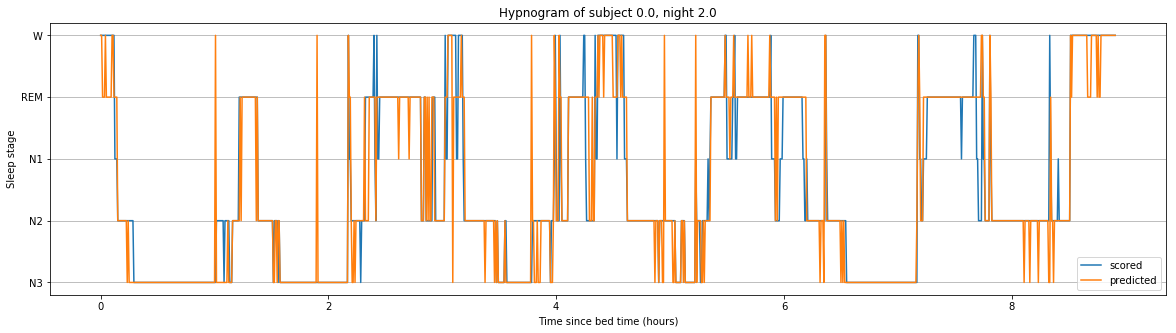

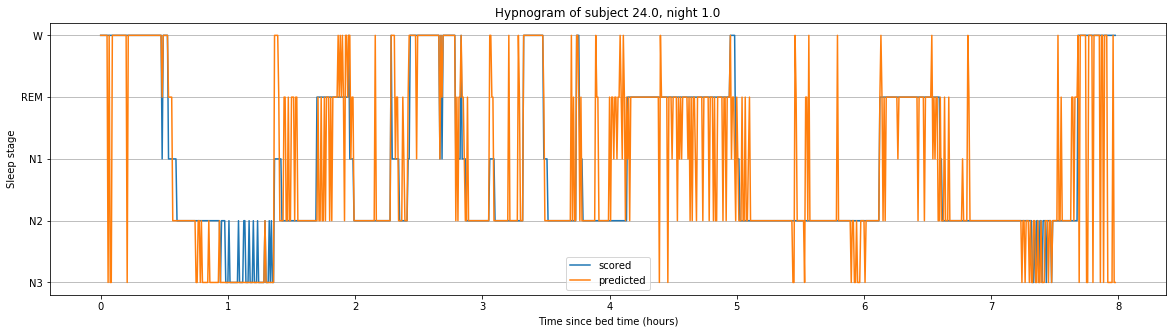

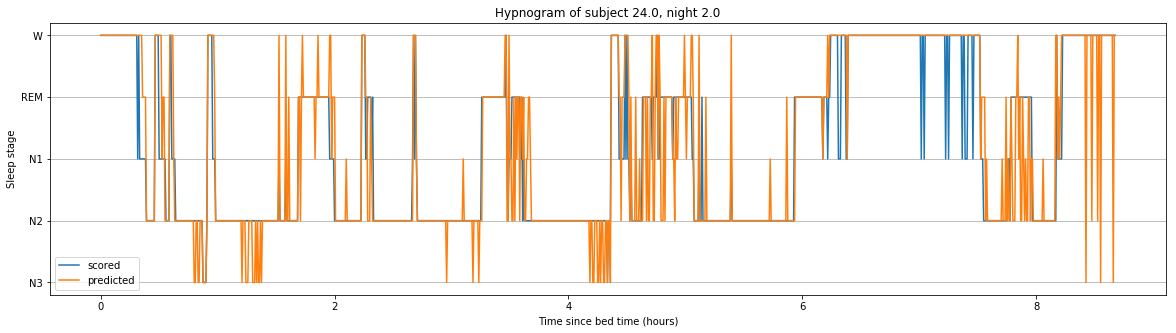

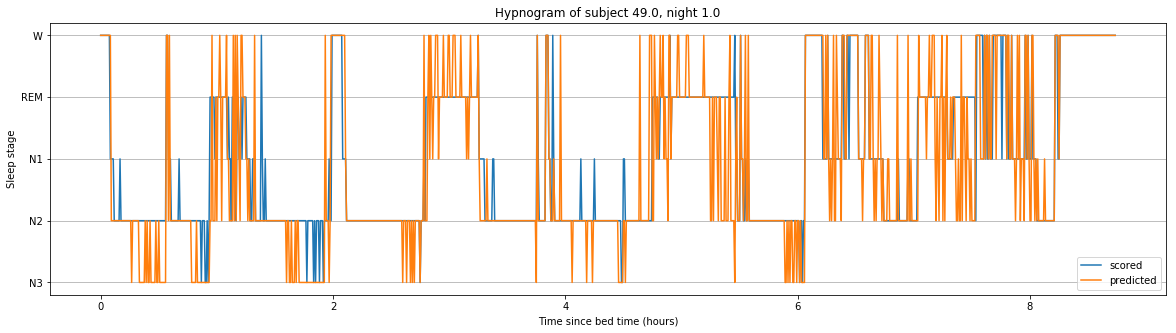

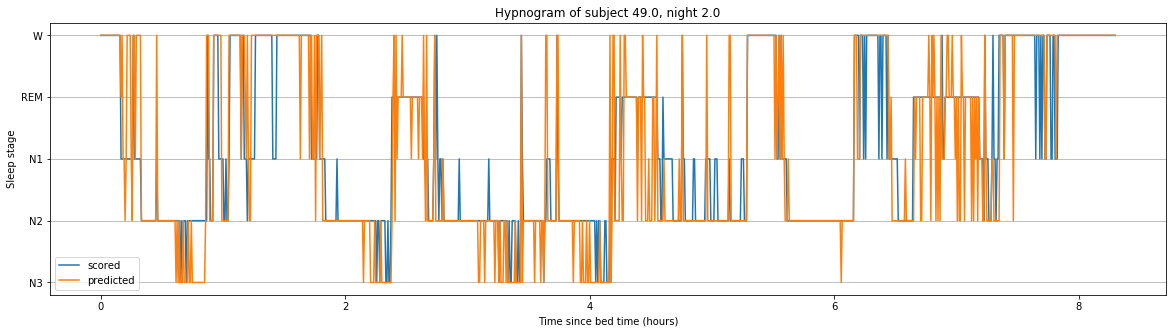

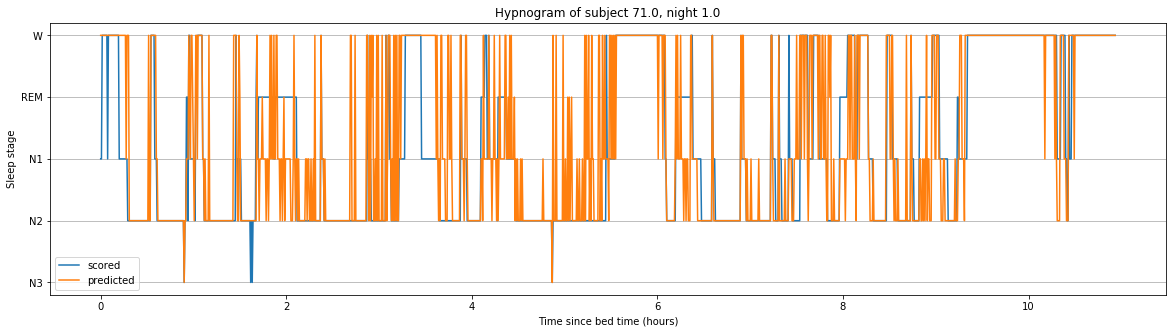

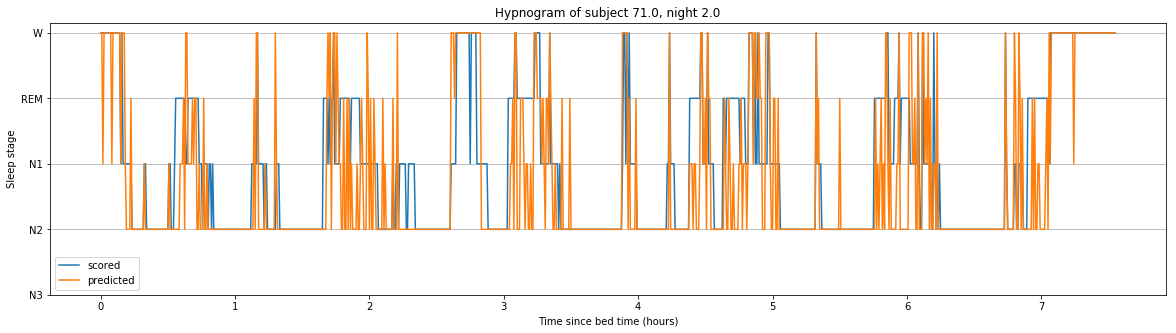

In [18]:
print("Test subjects are subjects: ", np.unique(X_test[:,0]))
plt.rcParams["figure.figsize"] = (20,5)

for test_subject in np.unique(X_test[:,0]):
    test_subject_indexes = [idx for idx, elem in enumerate(X_test) if elem[0] == test_subject]
    
    for night_idx in np.unique(X_test[test_subject_indexes,1]):
        test_night_subject_indexes = [
            idx for idx, elem in enumerate(X_test)
            if elem[0] == test_subject and elem[1] == night_idx]
        hypnograms = [
            y_test[test_night_subject_indexes],
            y_test_pred[test_night_subject_indexes]
        ]
        
        print_hypnogram(hypnograms,
                        labels=["scored", "predicted"],
                        subject=test_subject,
                        night=night_idx)

## Saving trained model
___


In [19]:
SAVED_DIR = "../trained_model"

if not os.path.exists(SAVED_DIR):
    os.mkdir(SAVED_DIR);

if USE_CONTINUOUS_AGE: 
    joblib.dump(testing_pipeline, f"{SAVED_DIR}/classifier_SVC_age_continuous.joblib")
else:
    joblib.dump(testing_pipeline, f"{SAVED_DIR}/classifier_SVC.joblib")